In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import altair as alt

from path_explain.path_explainer_tf import PathExplainerTF
from path_explain import utils
from plot.scatter import scatter_plot, _get_bounds
from plot.summary import summary_plot

In [3]:
utils.set_up_environment(visible_devices='0')

In [4]:
n = 5000
d = 5
noise = 0.5
X = np.random.randn(n, d)
y = np.sum(X, axis=-1) + 2 * np.prod(X[:, 0:2], axis=-1)

In [5]:
threshold = int(n * 0.8)
X_train = X[:threshold]
y_train = y[:threshold]
X_test  = X[threshold:]
y_test  = y[threshold:]

In [6]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(d,)))
model.add(tf.keras.layers.Dense(units=10,
                                use_bias=True,
                                activation=tf.keras.activations.softplus))
model.add(tf.keras.layers.Dense(units=5,
                                use_bias=True,
                                activation=tf.keras.activations.softplus))
model.add(tf.keras.layers.Dense(units=1,
                                use_bias=False,
                                activation=None))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


In [8]:
learning_rate = 0.1
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate),
              loss=tf.keras.losses.MeanSquaredError())

In [9]:
model.fit(X_train, y_train, batch_size=50, epochs=20, verbose=2, validation_split=0.8)

Train on 799 samples, validate on 3201 samples
Epoch 1/20
799/799 - 1s - loss: 8.0471 - val_loss: 28.5211
Epoch 2/20
799/799 - 0s - loss: 7.7223 - val_loss: 3.1325
Epoch 3/20
799/799 - 0s - loss: 3.3350 - val_loss: 4.3576
Epoch 4/20
799/799 - 0s - loss: 3.8947 - val_loss: 2.4479
Epoch 5/20
799/799 - 0s - loss: 2.4409 - val_loss: 1.6629
Epoch 6/20
799/799 - 0s - loss: 1.4553 - val_loss: 0.3957
Epoch 7/20
799/799 - 0s - loss: 3.8708 - val_loss: 4.2668
Epoch 8/20
799/799 - 0s - loss: 1.0741 - val_loss: 1.1157
Epoch 9/20
799/799 - 0s - loss: 0.8381 - val_loss: 1.2512
Epoch 10/20
799/799 - 0s - loss: 0.9054 - val_loss: 0.2994
Epoch 11/20
799/799 - 0s - loss: 0.3587 - val_loss: 0.1687
Epoch 12/20
799/799 - 0s - loss: 0.3089 - val_loss: 0.3025
Epoch 13/20
799/799 - 0s - loss: 0.2271 - val_loss: 0.6755
Epoch 14/20
799/799 - 0s - loss: 0.6562 - val_loss: 0.2318
Epoch 15/20
799/799 - 0s - loss: 0.3534 - val_loss: 0.1425
Epoch 16/20
799/799 - 0s - loss: 0.1447 - val_loss: 0.2088
Epoch 17/20
799/7

In [10]:
model.evaluate(X_test, y_test, batch_size=50, verbose=2)

1000/1000 - 0s - loss: 0.2893


0.28926376849412916

In [11]:
y_test_pred = model.predict(X_test, batch_size=50)

In [12]:
df = pd.DataFrame({
    'Predicted Outcome': y_test_pred[:, 0],
    'True Outcome': y_test
})
alt.Chart(df).mark_point(filled=True, opacity=0.3).encode(
    alt.X('True Outcome:Q'),
    alt.Y('Predicted Outcome:Q')
)

alt.Chart(...)

In [13]:
explainer = PathExplainerTF(model)

In [14]:
feature_values = X_test

## Using Expected Gradients

In [15]:
attributions = explainer.attributions(feature_values.astype(np.float32), X_train.astype(np.float32),
                     batch_size=100, num_samples=100,
                     use_expectation=True, output_indices=[0] * len(feature_values),
                     verbose=True)

100%|██████████| 1000/1000 [00:06<00:00, 156.16it/s]


In [16]:
interactions = explainer.interactions(feature_values.astype(np.float32), X_train.astype(np.float32),
                         batch_size=100, num_samples=100,
                         use_expectation=True, output_indices=[0] * len(feature_values),
                         verbose=True, interaction_index=None)

100%|██████████| 1000/1000 [03:35<00:00,  4.65it/s]


In [17]:
data_df = pd.DataFrame({
    'Attributions': attributions.flatten(),
    'Sum of Interactions': np.sum(interactions, axis=-1).flatten()
})
alt.Chart(data_df).mark_point().encode(
    alt.X('Attributions:Q'),
    alt.Y('Sum of Interactions')
)

alt.Chart(...)

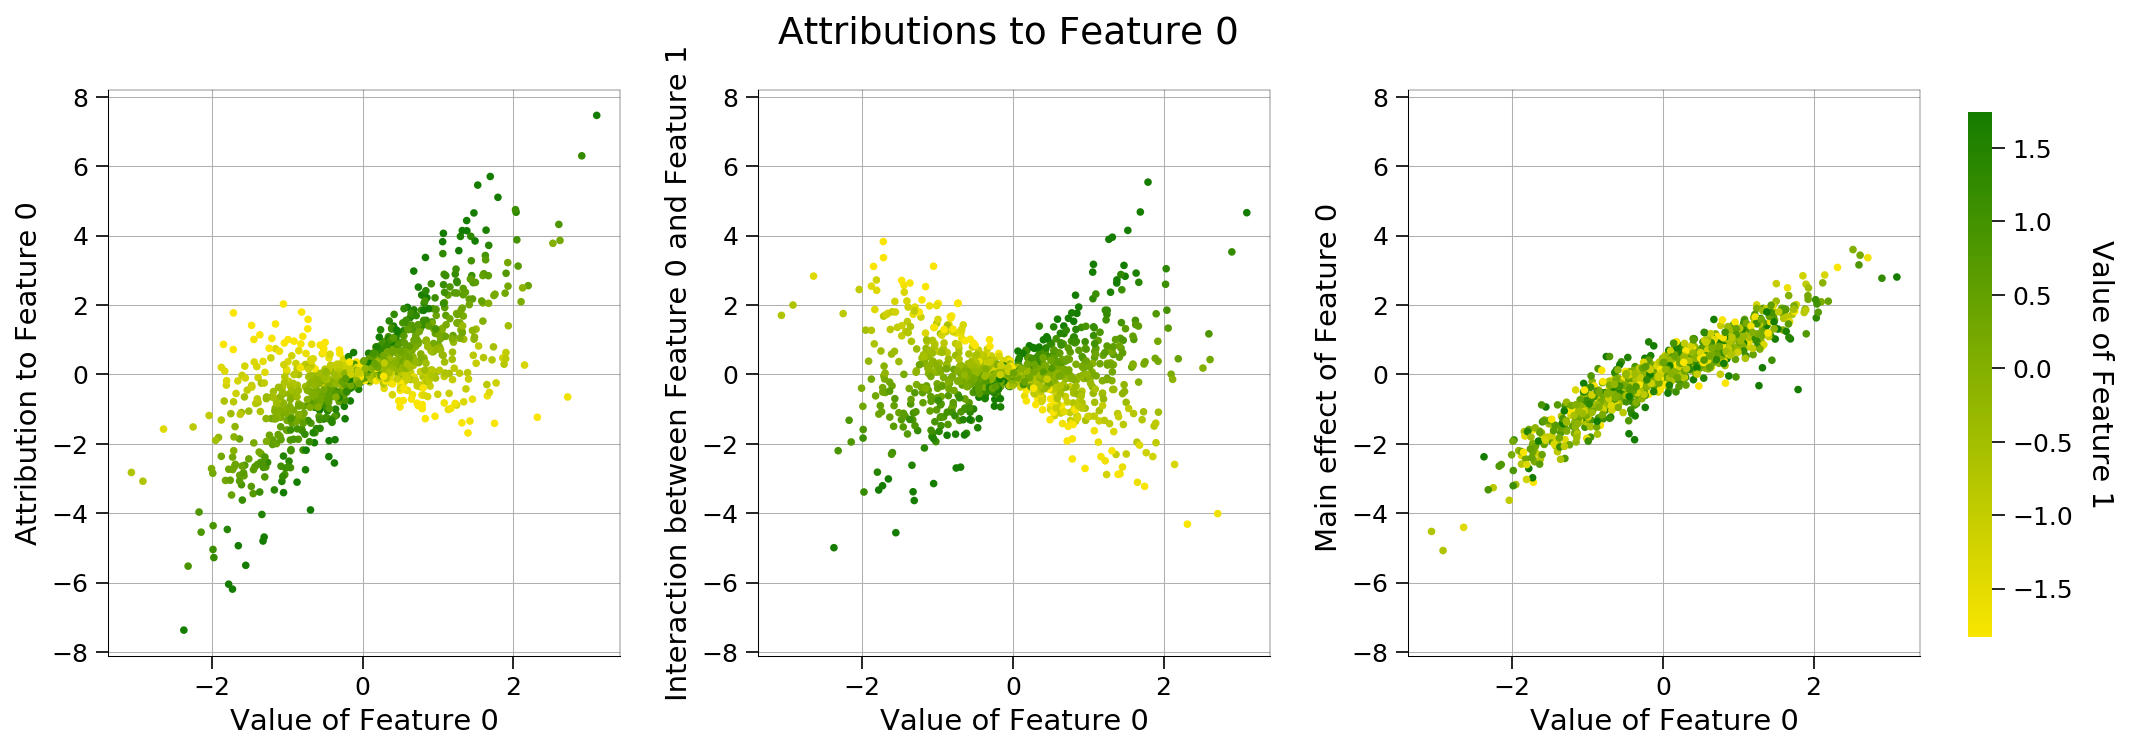

In [18]:
fig, axs = scatter_plot(attributions,
             feature_values,
             feature_index=0,
             interactions=interactions,
             color_by=1,
             feature_names=None)

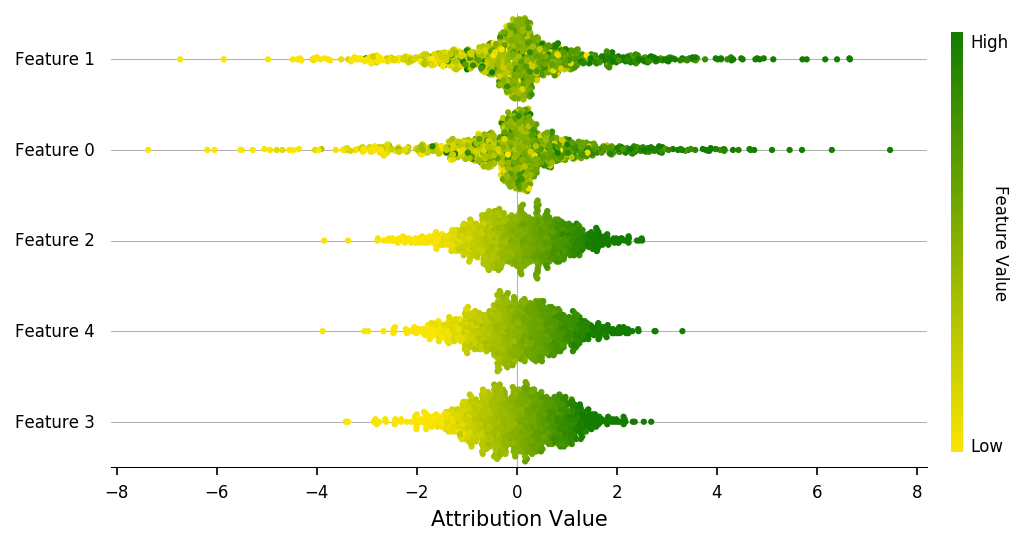

In [19]:
summary_plot(attributions,
             feature_values,
             interactions=None,
             interaction_feature=None,
             feature_names=None,
             plot_top_k=None)

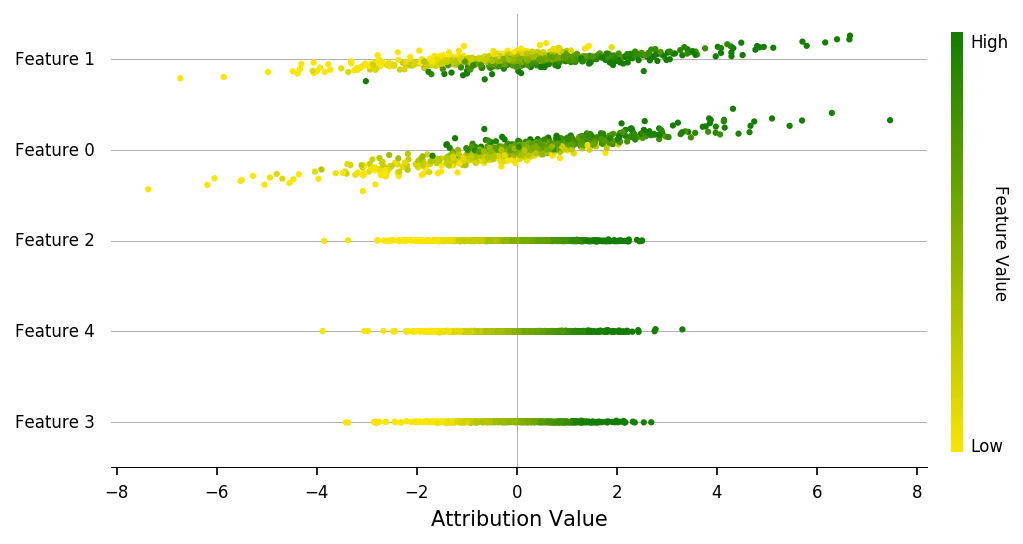

In [20]:
summary_plot(attributions,
             feature_values,
             interactions=interactions,
             interaction_feature=0,
             feature_names=None,
             plot_top_k=None)

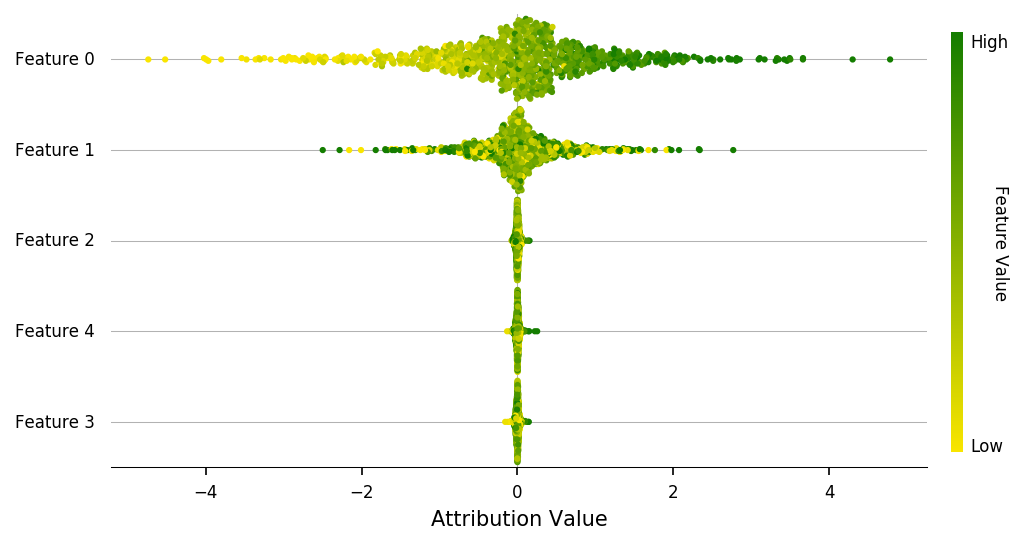

In [21]:
summary_plot(interactions[:, 0],
             feature_values,
             interactions=None,
             interaction_feature=None,
             feature_names=None,
             plot_top_k=None)

## Using Integrated Gradients

In [21]:
attributions = explainer.attributions(feature_values, np.zeros((1, 5)),
                     batch_size=100, num_samples=100,
                     use_expectation=False, output_indices=[0] * len(feature_values),
                     verbose=True)

100%|██████████| 1000/1000 [00:03<00:00, 332.27it/s]


In [22]:
interactions = explainer.interactions(feature_values, np.zeros((1, 5)),
                         batch_size=100, num_samples=100,
                         use_expectation=False, output_indices=[0] * len(feature_values),
                         verbose=True, interaction_index=None)

100%|██████████| 1000/1000 [02:49<00:00,  5.89it/s]


In [23]:
data_df = pd.DataFrame({
    'Attributions': attributions.flatten(),
    'Sum of Interactions': np.sum(interactions, axis=-1).flatten()
})
alt.Chart(data_df).mark_point().encode(
    alt.X('Attributions:Q'),
    alt.Y('Sum of Interactions')
)

alt.Chart(...)

In [24]:
k = 1
for i in range(5):
    print('Attribution to feature {}: {:.4f}'.format(i, attributions[k, i]))
    print('Interaction to feature {}: {}'.format(i, ', '.join(['{:.4f}'.format(inter) for inter in interactions[k, i]])))
    print('-----------------------------')

Attribution to feature 0: -0.0821
Interaction to feature 0: -0.1533, 0.0792, -0.0055, -0.0038, -0.0013
-----------------------------
Attribution to feature 1: -0.1805
Interaction to feature 1: 0.0792, -0.2554, -0.0044, -0.0029, -0.0015
-----------------------------
Attribution to feature 2: -0.3892
Interaction to feature 2: -0.0055, -0.0044, -0.3760, -0.0029, -0.0011
-----------------------------
Attribution to feature 3: -0.4453
Interaction to feature 3: -0.0038, -0.0029, -0.0029, -0.4356, -0.0010
-----------------------------
Attribution to feature 4: -0.1461
Interaction to feature 4: -0.0013, -0.0015, -0.0011, -0.0010, -0.1416
-----------------------------


In [28]:
scatter_plot(attributions,
             feature_values,
             feature_index=0,
             interactions=interactions,
             color_by=1,
             feature_names=None)

alt.HConcatChart(...)

In [26]:
summary_plot(attributions,
             feature_values,
             interactions=interactions,
             interaction_feature=0,
             feature_names=None,
             plot_top_k=None)

alt.Chart(...)

In [27]:
summary_plot(interactions[:, 0],
             feature_values,
             interactions=None,
             interaction_feature=None,
             feature_names=None,
             plot_top_k=None)

alt.Chart(...)